## 搭建一个分词工具

###  基于枚举方法来搭建中文分词工具

此项目需要的数据：
1. 综合类中文词库.xlsx： 包含了中文词，当做词典来用
2. 以变量的方式提供了部分unigram概率 word_prob


举个例子： 给定词典=[我们 学习 人工 智能 人工智能 未来 是]， 另外我们给定unigram概率：p(我们)=0.25, p(学习)=0.15, p(人工)=0.05, p(智能)=0.1, p(人工智能)=0.2, p(未来)=0.1, p(是)=0.15

#### 对于给定字符串：”我们学习人工智能，人工智能是未来“, 找出所有可能的分割方式
- [我们，学习，人工智能，人工智能，是，未来]
- [我们，学习，人工，智能，人工智能，是，未来]
- [我们，学习，人工，智能，人工，智能，是，未来]
- [我们，学习，人工智能，人工，智能，是，未来]
.......


#### 我们也可以计算出每一个切分之后句子的概率
- p(我们，学习，人工智能，人工智能，是，未来)= -log p(我们)-log p(学习)-log p(人工智能)-log p(人工智能)-log p(是)-log p(未来)
- p(我们，学习，人工，智能，人工智能，是，未来)=-log p(我们)-log p(学习)-log p(人工)-log p(智能)-log p(人工智能)-log p(是)-log p(未来)
- p(我们，学习，人工，智能，人工，智能，是，未来)=-log p(我们)-log p(学习)-log p(人工)-log p(智能)-log p(人工)-log p(智能)-log p(是)-log p(未来)
- p(我们，学习，人工智能，人工，智能，是，未来)=-log p(我们)-log p(学习)-log p(人工智能)-log p(人工)-log p(智能)-log(是)-log p(未来)
.....

#### 返回第二步中概率最大的结果

In [6]:
class TreeNode(object):
    def __init__(self):
        self.data = {}
        self.prob = 10**-8
        self.is_word = False


class DictTree(object):
    def __init__(self):
        self.root = TreeNode()

    def insert_data(self, word, prob):
        node = self.root
        for char in word:
            if not node.data.get(char):
                node.data[char] = TreeNode()
            node = node.data[char]
        node.prob = prob
        node.is_word = True

    def search_data(self, word):
        node = self.root
        for char in word:
            node = node.data.get(char)
            if not node:
                return TreeNode().prob
        return node.prob

In [2]:
# 第一步： 从dic.txt中读取所有中文词。
import pandas as pd
dt = DictTree()
# 保存词典库中读取的单词
df = pd.read_excel("./data/综合类中文词库.xlsx",header=None, encoding="utf8")
for idx in df.index:
    data = df.loc[idx][0]
    prob = df.loc[idx][2]*(10**-7)
    dt.insert_data(data,prob)

In [7]:
class Solution(object):
    def check(self, s):
        dp = [False for i in range(len(s)+1)]
        dp[0] = True
        for i in range(1, len(s)+1):
            for k in range(0, i):
                if dp[k] and dt.search_data(s[k:i])!=10**-8:
                    dp[i] = True
        return dp[len(s)]
        
    def dfs(self, s, stringlist):
        if self.check(s):
            if len(s) == 0: Solution.res.append(stringlist[1:])
            for i in range(1, len(s)+1):
                # 核心代码
                if dt.search_data(s[:i])!=10**-8:
                    self.dfs(s[i:], stringlist+" "+s[:i])
    def wordBreak(self, s):
        Solution.res = []
        self.dfs(s,"")
        result = [s.split(" ") for s in Solution.res]
        return result

In [8]:
## 请编写word_segment_naive函数来实现对输入字符串的分词
import numpy as np
def word_segment_naive(input_str):
    """
    input_str: 输入字符串   输入格式：“今天天气好”
    best_segment: 最好的分词结果  输出格式：["今天"，"天气"，"好"]
    """

    # 第一步： 计算所有可能的分词结果，要保证每个分完的词存在于词典里，这个结果有可能会非常多。 
    slt = Solution()
    segments = slt.wordBreak(input_str)  # 存储所有分词的结果。如果次字符串不可能被完全切分，则返回空列表(list)
    # 格式为：segments = [["今天"，“天气”，“好”],["今天"，“天“，”气”，“好”],["今“，”天"，“天气”，“好”],...]
    best_segment = segments[0]
    best_score = np.sum([np.log(dt.search_data(s)) for s in segments[0]])
    for seg in segments[1:]:
        score = 0
        for s in seg:
            score += np.log(dt.search_data(s))
        if score > best_score:
            best_score = score
            best_segment = seg
    return best_segment      

In [9]:
# 测试
print(word_segment_naive("北京的天气真好啊"))
print(word_segment_naive("经常有意见分歧"))

['北京', '的', '天气', '真好', '啊']
['经常', '有意', '见', '分歧']


###  基于维特比算法来优化上述流程

此项目需要的数据：
1. 综合类中文词库.xlsx： 包含了中文词，当做词典来用
2. 以变量的方式提供了部分unigram概率word_prob


举个例子： 给定词典=[我们 学习 人工 智能 人工智能 未来 是]， 另外我们给定unigram概率：p(我们)=0.25, p(学习)=0.15, p(人工)=0.05, p(智能)=0.1, p(人工智能)=0.2, p(未来)=0.1, p(是)=0.15

#### 根据词典，输入的句子和 word_prob来创建带权重的有向图（Directed Graph）
有向图的每一条边是一个单词的概率（只要存在于词典里的都可以作为一个合法的单词），这些概率已经给出（存放在word_prob）。

####  编写维特比算法（viterebi）算法来找出其中最好的PATH， 也就是最好的句子切分

#### 返回结果

In [363]:
## 编写word_segment_viterbi函数来实现对输入字符串的分词
def word_segment_viterbi(input_str):
    """
    1. 基于输入字符串，词典，以及给定的unigram概率来创建DAG(有向图）。
    2. 编写维特比算法来寻找最优的PATH
    3. 返回分词结果
    input_str: 输入字符串   输入格式：“今天天气好”
    best_segment: 最好的分词结果  输出格式：["今天"，"天气"，"好"]
    """
    # 第一步：根据词典，输入的句子，以及给定的unigram概率来创建带权重的有向图（Directed Graph） 
    # 有向图的每一条边是一个单词的概率（只要存在于词典里的都可以作为一个合法的单词），这些概率在 word_prob，如果不在word_prob里的单词但在
    # 词典里存在的，统一用概率值0.00001。
    # 注意：思考用什么方式来存储这种有向图比较合适？ 不一定有只有一种方式来存储这种结构。 
    graph, route, N = {}, {}, len(input_str)
    for n,i in enumerate(input_str):
        key, value_list = n, []
        for j in range(n, N):
            if dt.search_data(input_str[n:j+1]) != 10**-8:
                # 计算每个节点由哪些节点到达
                value_list.append(j)
        if not value_list:
            value_list.append(key)
        graph[key] = value_list
    # 第二步： 利用维特比算法来找出最好的PATH， 这个PATH是P(sentence)最大或者 -log P(sentence)最小的PATH。
    # 因为概率过小连乘的时候容易出现溢出，unf的情况 ，hint: 思考为什么不用相乘: p(w1)p(w2)...而是使用negative log sum:  -log(w1)-log(w2)-...
    best_route = viterbi_dp(input_str ,graph, route)
    # 第三步： 根据最好的PATH, 返回最好的切分
    start, cut_list =0, []
    for i in range(start, N):
        cut_word = input_str[start:best_route[start][1] + 1]
        if cut_word:
            cut_list.append(cut_word)
        if start < N :
            start = best_route[start][1] + 1
    return cut_list

In [364]:
def viterbi_dp(sentence, group, route):
    N, route[len(sentence)]= len(sentence),(0,0)
    for idx in range(N-1, -1, -1):
        all_rout = []
        for x in group[idx]:
            c_x = -np.log2(dt.search_data(sentence[idx:x+1]))
            f_x = route[x+1][0]
            all_rout.append((c_x+f_x, x))
        route[idx] = min(all_rout)  
    return route

In [365]:
# 测试
print(word_segment_naive("北京的天气真好啊"))
print(word_segment_naive("经常有意见分歧"))

['北京', '的', '天气', '真好', '啊']
['今天', '的', '课程', '内容', '很', '有意思']
['经常', '有意', '见', '分歧']


In [ ]:
# 有哪些可以考虑的方法？
- 0.目前的概率是不完整的，可以考虑大量的语料库，然后从中计算出每一个词出现的概率，这样更加真实
- 1.加入2-gram或者3-gram 语言模型，考虑每个词前后词概率统计，这样让每个词特征更丰富,句子更像一个句子
- 2.加入一些平滑项来解决部分为出现的词的对最后结果的干扰
- 3.加入词性的信息，让一个句子词性也得符合一个合理的句子

##  搭建一个简单的问答系统

本次项目的目标是搭建一个基于检索式的简单的问答系统。至于什么是检索式的问答系统

通过此项目，你将会有机会掌握以下几个知识点：
1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

此项目需要的数据：
1. dev-v2.0.json: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. glove.6B: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=100的词向量

##### 检索式的问答系统
问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 <问题、答案>。 那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可

In [2]:
import json
def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    with open("./data/train-v2.0.json",encoding="utf8")as f:
        datas = json.load(f)
    qlist, alist = [], []
    for dat_p in datas["data"]:
        for pg in dat_p["paragraphs"]:
            for qa in pg["qas"]:
                if qa["answers"] and qa["question"]:
                    question, answer =qa["question"], qa["answers"][0]["text"]
                    qlist.append(question)
                    alist.append(answer)
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist

### 第一部分： 读取文件，并把内容分别写到两个list里（一个list对应问题集，另一个list对应答案集）

###  理解数据（可视化分析/统计信息）

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import itertools
# 统计一下在qlist 总共出现了多少个单词？ 总共出现了多少个不同的单词？
qlist, alist = read_corpus()
word_total = Counter(list(itertools.chain.from_iterable([q.split(" ") for q in qlist])))

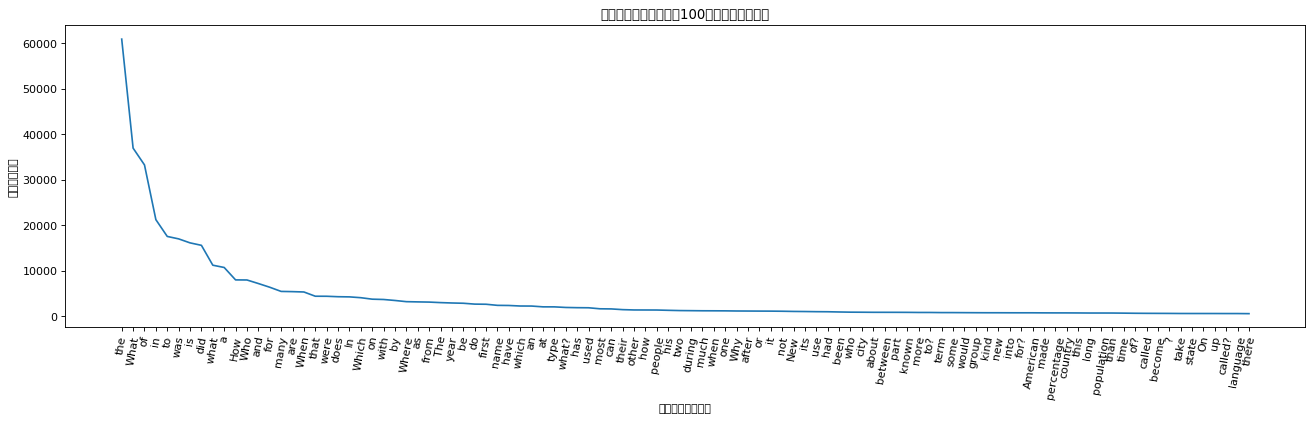

In [4]:
word_node = sorted(word_total.items(), key=lambda x: x[1], reverse = True)
key_list = [w[0] for w in word_node if w[0]][:100]
value_list = [w[1] for w in word_node if w[0]][:100]
plt.figure(figsize=(20,5),dpi=80)
plt.plot(range(len(key_list)),value_list)
plt.xticks(range(len(key_list)),key_list,rotation=80)
plt.xlabel("数据集中出现单词")
plt.ylabel("每个单词词频")
plt.title("根据词频大小排序的前100个单词的分布情况")
plt.show()



In [5]:
# 在qlist和alist里出现次数最多的TOP 10单词分别是什么？ 
question_words =  Counter(list(itertools.chain.from_iterable([q.split(" ") for q in qlist])))
q_word = sorted(question_words.items(), key=lambda x: x[1], reverse = True)
answer_words = Counter(list(itertools.chain.from_iterable([q.split(" ") for q in alist])))
a_word = sorted(answer_words.items(), key=lambda x: x[1], reverse = True)
top_q, top_a = [q[0] for q in q_word if q[0]][:10], [a[0] for a in a_word if a[0]][:10]
print(top_q)
print(top_a)

['the', 'What', 'of', 'in', 'to', 'was', 'is', 'did', 'what', 'a']
['the', 'of', 'and', 'to', 'a', 'in', 'The', 'or', 'for', 'million']


In [6]:
# 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
def is_number(s):
    if "|" in s:
        return s
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

In [7]:
import re
#  3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#  2. 转换成lower_case： 这是一个基本的操作  
def sub_word(s):
    text = s.lower()
    tmp = re.compile("[a-zA-Z'0-9\s]+").findall(text)
    if len(tmp):  
        return tmp[0]
    else:
        return ""

### 文本预处理
次部分需要尝试做文本的处理。在这里我们面对的是英文文本，所以任何对英文适合的技术都可以考虑进来。

In [8]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# 列表总次数
question_word_total = sum([q[1] for q in q_word])
# 查看占比  question 
q_count_ratio = {node[0]:"%.5f"%(node[1]/question_word_total) for node in q_word}
# 低频词
q_low_ratio = [node[0] for node in q_word if node[1] <= 13]
ps = PorterStemmer()
qlist_len = len(qlist)
# 文本预处理函数
def text_preprocessing(question):
    sentence = []
    for q in question.split(" "):
        # 执行了 4
        if q not in q_low_ratio:
            # 执行了 2,3
            text = sub_word(q)
            # 执行了 1
            if text and text not in stopwords.words("english"):
                # 执行了 5
                if is_number(text):
                    text = "#number"
                else:
                    # 执行了 6
                    text = ps.stem(text)
                sentence.append(text)
    return " ".join(sentence)

In [ ]:
#对于qlist, alist做文本预处理操作。 可以考虑以下几种操作：
#1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页，或者直接使用NLTK自带的）   
#2. 转换成lower_case： 这是一个基本的操作   
#3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#4. 去掉出现频率很低的词：比如出现次数少于10,20....
#5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
# 6. stemming（利用porter stemming): 因为是英文，所以stemming也是可以做的工作
# 7. 其他（如果有的话）
#  请注意，不一定要按照上面的顺序来处理，具体处理的顺序思考一下，然后选择一个合理的顺序
qlist_len = len(qlist)
new_qlist = []
for n, question in enumerate(qlist):
    nq = text_preprocessing(question)
    new_qlist.append(nq)
#     print("已完成%d，已完成%.2f"%(n, (n*100)/qlist_len)+" %")
qlist, alist = new_qlist, alist  # 更新后的

In [37]:
#根据每个单词在文档的次数和总次数的占比决定的（以上选取低于 0.00002以下的及出现少于13次的去掉）

### 文本表示
当我们做完关键的预处理过程之后，就需要把每一个文本转换成向量。

In [10]:
# 生成 tfidf vectorizer
def gen_tfidf(x, D, ds ,dw):
    """
    x: 输入的句子
    D: 词典
    ds: 总文档数
    dw：文档所有的单词的词频
    """
    q = Counter(x.split(" "))
    sentence_len = len(q)
    vectorizer = []  # 定义一个tf-idf的vectorizer
    for d in D:
        w_count = q.get(d,0)
        if w_count == 0:
            w_c = 0
        else:
            tf = w_count/sentence_len
            idf = np.log(ds/dw[d])
            w_c = tf*idf
        vectorizer.append(w_c)
    return vectorizer

In [11]:
# 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N* D的矩阵。 这里N是问题的个数（样本个数），
# D是字典库的大小。
D = list(set(list(itertools.chain.from_iterable([q.split(" ") for q in qlist]))))
doc_wcount = {}
for d in D:
    count = 0
    for q in qlist:
        if d in q:
            count += 1
    doc_wcount[d] = count
docs, X ,v_count= len(qlist), [], 0
for question in qlist:
    vectorizer = gen_tfidf(question,D,docs,doc_wcount)
    v_count += len([v for v in vectorizer if v != 0])
    # X =   # 结果存放在X矩阵
    X.append(vectorizer)

In [12]:
# 计算一下它的稀疏度
sparsity = 1-(v_count/(len(D)*len(qlist)))
print("sparsity is %.2f %%"% (sparsity*100))  # 打印出稀疏度(sparsity)

sparsity is 99.87 %


### 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

In [13]:
def cosine(x,y):
    x, y = np.array(x), np.array(y)
    nu = np.dot(x,y)
    de = np.linalg.norm(x)*np.linalg.norm(y)
    if de == 0:
        return 0
    cos =  nu/de
    return 0.5 + 0.5 *cos

In [14]:
def top5results(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    input_q = text_preprocessing(input_q)
    vec = gen_tfidf(input_q, D, docs, doc_wcount)
    top_idxs = sorted([[alist[n],cosine(x,vec)] for n, x in enumerate(X)],key=lambda x: x[1])
    return top_idxs[-5:]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [15]:
# 编写几个测试用例，并输出结果
print (top5results("beyonc grammi nomin femal"))
print (top5results("trip back berlin chopin guest"))

[['ten nominations', 0.8572919521579055], ['ten', 0.8904413437327359], ['52 nominations', 0.9267350551836099], ['52', 0.9267350551836099], ['Lauryn Hill', 1.0]]
[['Fanny Vandegrift Stevenson', 0.7291858842423264], ['November 1806', 0.7573503059230023], ['city was spared for a negotiated ransom of 200,000 thalers', 0.7573503059230023], ['Prince Antoni Radziwiłł', 0.8086512788719262], ['Prince Antoni Radziwiłł', 0.9737760483460378]]


###  利用倒排表的优化。 
上面的算法，一个最大的缺点是每一个用户问题都需要跟库里的所有的问题都计算相似度。假设我们库里的问题非常多，这将是效率非常低的方法。 这里面一个方案是通过倒排表的方式，先从库里面找到跟当前的输入类似的问题描述。然后针对于这些candidates问题再做余弦相似度的计算。这样会节省大量的时间。

In [16]:
#基于倒排表的优化。在这里，我们可以定义一个类似于hash_map, 比如 inverted_index = {}， 然后存放包含每一个关键词的文档出现在了什么位置，
#也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），然后对于candidates问题做相似度比较。

def top5results_invidx(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    inverted_idx = {d:[X[n] for n,q in enumerate(qlist)if d in q]for d in D}  # 定一个一个简单的倒排表
    input_q = text_preprocessing(input_q)
    vec = gen_tfidf(input_q, D, docs, doc_wcount)
    # 选取候选集
    candidate = []
    for q in input_q.split(" "):
        iiq = inverted_idx.get(q,None)
        if iiq:
            candidate += iiq
    top_idxs = sorted([[alist[n],cosine(x,vec)] for n, x in enumerate(candidate)],key=lambda x: x[1])
    return top_idxs[-5:]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [17]:
#编写几个测试用例，并输出结果
print (top5results_invidx("beyonc grammi nomin femal"))
print (top5results_invidx("trip back berlin chopin guest"))

[['People', 0.9267350551836099], ['Dangerously in Love Tour', 1.0], ['greatest entertainer alive', 1.0], ['2006', 1.0], ['Drake', 1.0]]
[['Jay Z', 0.8086512788719262], ['in the late 1990s', 0.9737760483460378], ['Dreamgirls', 0.9737760483460378], ['four', 0.9737760483460378], ['Forbes', 0.9737760483460378]]


### 基于词向量的文本表示
上面所用到的方法论是基于词袋模型（bag-of-words model）。这样的方法论有两个主要的问题：1. 无法计算词语之间的相似度  2. 稀疏度很高。 在2.7里面我们
讲采用词向量作为文本的表示。词向量方面需要下载： https://nlp.stanford.edu/projects/glove/ （请下载glove.6B.zip），并使用d=100的词向量（100维）。


In [51]:
with open("./data/glove.6B.100d.txt",encoding="utf8")as f:
    emb = {d.split(" ")[0]: d.strip().split(" ")[1:] for d in f.readlines()if d}
inverted_idx = {d:[qlist[n] for n,q in enumerate(qlist)if d in q]for d in D}  # 定一个一个简单的倒排表

In [52]:
def gen_sentence_vec(w2v,sentence):
    if not type(sentence) is list:
        sentence = sentence.split(" ")
    _vec, count = [], len(sentence)
    if count == 0:
        return 0
    for w in sentence:
        wv = w2v.get(w,None)
        if wv:
            wv = list(map(float,wv))
            _vec.append(wv)
    s2v = (np.sum(np.array(_vec),axis=0) / count)
    return s2v.tolist()

In [59]:
# 读取每一个单词的嵌入。这个是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 这里面我们给定的每个单词的词向量，那句子向量怎么表达？
# 其中，最简单的方式 句子向量 = 词向量的平均（出现在问句里的）， 如果给定的词没有出现在词典库里，则忽略掉这个词。

def top5results_emb(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q，转换成句子向量
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    input_q = text_preprocessing(input_q)
    vec = gen_sentence_vec(emb,input_q)
    # 选取候选集
    candidate = []
    for q in input_q.split(" "):
        # iiq 是文档
        iiq = inverted_idx.get(q,None)
        if iiq:
            sen2vce = gen_sentence_vec(emb,iiq)
            candidate.append(sen2vce)
    top_idxs = sorted([[alist[n],cosine(x,vec)] for n, x in enumerate(candidate)],key=lambda x: x[1])
    return top_idxs[-5:]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [60]:
# 编写几个测试用例，并输出结果
print (top5results_emb("beyonc grammi nomin femal"))
print (top5results_emb("trip back berlin chopin guest"))

[['singing and dancing', 0], ['2003', 0], ['Houston, Texas', 0], ['in the late 1990s', 1.0]]
[['in the late 1990s', 0], ['Houston, Texas', 0], ['2003', 0.8464751821925707], ['singing and dancing', 0.8818963094195704]]
